In [1]:
# enable inline plotting
%matplotlib inline
# uncomment this line to open a console with the same kernel
%qtconsole

import numpy as np
import pandas as pd
import cma

import scipy.stats as stats

import matplotlib.pyplot as plt

from kkr import *

/home/gebhardt/bin/miniconda3/envs/kkf/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
The bokeh.charts API has moved to a separate 'bkcharts' package.

This compatibility shim will remain until Bokeh 1.0 is released.
After that, if you want to use this API you will have to install
the bkcharts package explicitly.

  warn(message)


Loading BokehJS ...

configure some parameters

In [2]:
default_alpha_t = -8
default_alpha_o = -8
default_alpha_q = -6

# bandwidth of the kernel function k and g
default_bandwidth_factor_k = np.log(1)
default_bandwidth_factor_g = np.log(1)

# Simulation parameters
num_steps = 30
num_episodes = 100
observation_idx = list(range(30))

num_test_episodes = 10

process_noise_std = .01
observation_noise_std = .3

# Model parameters
# number of data points in the kernel matrices
kernel_size = 200
subspace_size = 100

window_size = 4

state_features = 'thetaNoisy'
obs_features = 'thetaNoisy'

cma_initial_var = .2
cma_iterations = 50

Simulate the data

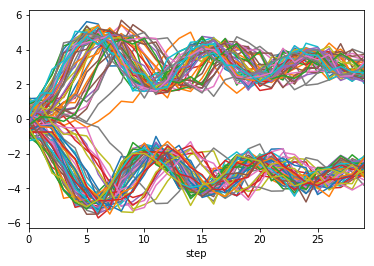

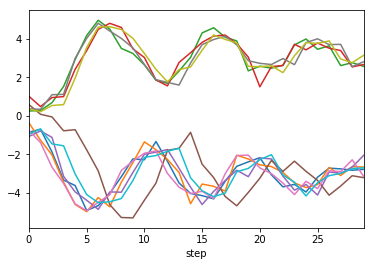

In [3]:
np.random.seed(1)

# Simulate pendulum
pendulum = Pendulum()
pendulum.noise_std = process_noise_std
pendulum.dt = .1

simulator = Simulator(pendulum, stats.uniform(loc=np.array([-.25, -2]) * np.pi, scale=np.array([.5, 4]) * np.pi).rvs)

# simulate data
data = simulator.simulate(num_episodes, num_steps)
add_noise(data, 'theta', noise_generator=stats.norm(loc=.0, scale=observation_noise_std))
# Sample evaluation data
testData = simulator.simulate(num_test_episodes, num_steps)
add_noise(testData, 'theta', noise_generator=stats.norm(loc=.0, scale=observation_noise_std))

# create observations
testData['observations'] = testData.loc[(slice(None), observation_idx), obs_features]


_ = data['thetaNoisy'].unstack(0).plot(legend=False)
_ = testData['thetaNoisy'].unstack(0).plot(legend=False)

## Preprocess the data

Now we learn the filter from this data. First, we need to create data windows to make the data more Markovian. See [here](preprocessor/preprocessors.py) for how the data windows are generated.

In [4]:
windows = generate_data_windows(data[state_features], window_size)

# get initial states of the data
gb = windows.groupby(level='episode')
_X0 = gb.first()[state_features].values

## Compute the bandwidths

In [5]:
np.random.seed(2)

bandwidths = compute_median_bandwidth(windows[state_features])

## Select training data

In [6]:
kernel_ref = ExponentialQuadraticKernel()
kernel_ref.bandwidth = bandwidths
reference_set1, reference_set2, reference_set3 = \
        select_reference_set_by_kernel_activation(windows, size=kernel_size, 
                                                  kernel_function=kernel_ref,
                                                  consecutive_sets=3, group_by='episode')
reference_set_subspace = select_reference_set_by_kernel_activation(windows.loc[reference_set1],
                                                                   size=subspace_size,
                                                                   kernel_function=kernel_ref)

_X1 = windows.loc[reference_set1, state_features].values
_X2 = windows.loc[reference_set2, state_features].values
_X3 = windows.loc[reference_set3, state_features].values
_Y1 = data.loc[reference_set1, obs_features].values.reshape((-1, 1))
_Y2 = data.loc[reference_set2, obs_features].values.reshape((-1, 1))
_Xr = windows.loc[reference_set_subspace, state_features].values
# _Xout = data.loc[reference_set2, out_features].values

observations = testData['observations'].unstack(level=0).values
observation_dim = testData['observations'].ndim
observations = observations.reshape(-1, observation_dim, num_test_episodes)

groundtruth = testData['theta'].unstack(level=0).values
groundtruth_dim = testData['theta'].ndim
groundtruth = groundtruth.reshape(-1, groundtruth_dim, num_test_episodes)

## Create KKF Evaluation

In [7]:
evaluation = FilterEvaluation()

train_data = {'states_1': _X1,
              'states_2': _X2,
#               'subspace_states': _Xr,
              'observations': _Y2,
              'init_states': _X0,
              'preimage_states': _Y2}

evaluation.setup_evaluation(train_data=train_data, test_observations=observations,
                            test_groundtruth=groundtruth)

parameter_names = ['bandwidth_k', 'bandwidth_g',
                   'alpha_t', 'alpha_o', 'alpha_q']


@parameter_naming(parameter_names)
@parameter_transform(np.exp)
@bandwidth_factor(bandwidth_k=bandwidths, bandwidth_g=bandwidths[0])
@exception_catcher(np.linalg.linalg.LinAlgError, 1e4)
def eval_experiment(**kwargs):
    return evaluation.evaluate_loglikelihood(**kwargs)

## Optimize the Parameters

In [ ]:
x_0 = [default_bandwidth_factor_k, default_bandwidth_factor_g,
       default_alpha_t, default_alpha_o, default_alpha_q]

cma_opt = cma.CMAEvolutionStrategy(x_0, cma_initial_var)

In [9]:
cma_opt.optimize(objective_fct=eval_experiment, iterations=cma_iterations, verb_disp=1)

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
   51    408 -1.743652716676023e+03 2.3e+01 2.15e-01  4e-02  4e-01 16:59.9
   52    416 -1.741782875413528e+03 2.2e+01 1.79e-01  3e-02  3e-01 17:21.7
   53    424 -1.768997475358337e+03 2.3e+01 1.54e-01  3e-02  3e-01 17:48.4
   54    432 -1.774730890235232e+03 2.3e+01 1.44e-01  2e-02  2e-01 18:17.2
   55    440 -1.768577765421931e+03 2.1e+01 1.38e-01  2e-02  2e-01 18:42.1
   56    448 -1.764227388989339e+03 2.0e+01 1.38e-01  2e-02  2e-01 19:4.6
   57    456 -1.747825003188972e+03 2.1e+01 1.38e-01  2e-02  2e-01 19:29.2
   58    464 -1.764240534461372e+03 2.0e+01 1.47e-01  2e-02  2e-01 19:49.7
   59    472 -1.770156530433265e+03 2.0e+01 1.34e-01  2e-02  2e-01 20:14.0
   60    480 -1.776473210254198e+03 2.1e+01 1.23e-01  2e-02  2e-01 20:34.9
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
   61    488 -1.776118786300811e+03 2.2e+01 1.11e-01  2e-02  2e-01 20:55.2
   62    496 -1.780545552553022e

(array([  0.12076864,   0.21285928, -12.81519233, -13.38602727,  -6.60298622]),
 -1796.7301684531587,
 793,
 800,
 100,
 array([  0.12070289,   0.21267469, -12.81460643, -13.38673285,  -6.60286932]),
 array([ 0.00029474,  0.00026469,  0.00247877,  0.00449215,  0.00056731]))

### Retrieve optimal parameters

In [10]:
result = cma_opt.result()

best_params = dict(zip(parameter_names, np.exp(result[0])))

best_params

{'alpha_o': 1.5364634070327767e-06,
 'alpha_q': 0.0013563117416184804,
 'alpha_t': 2.7191470063868891e-06,
 'bandwidth_g': 1.2372105406108429,
 'bandwidth_k': 1.1283638207582471}

### Re-Learn the KKF

In [11]:
evaluation.model.learn_model(**best_params)

## Evaluate the kernel Kalman filter

In [12]:
observations = testData['observations'].unstack(level=0).values

observations = observations.reshape(-1, 1, num_test_episodes)

mu, sigma = evaluation.model.filter(observations)

testData['mu'] = np.moveaxis(mu, 2, 0).reshape(-1, 1)
testData['sigma'] = np.tile(np.squeeze(np.sqrt(sigma)), num_test_episodes)

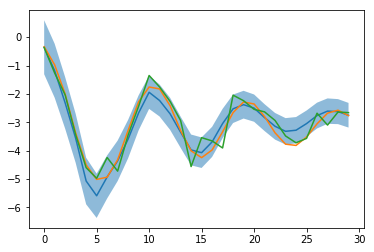

In [15]:
def plot_errorbar(x, y, error, linespec='-'):
    import matplotlib.pyplot as plt
    
    _l, = plt.plot(x, y, linespec)
    plt.fill_between(x, y-error, y+error, alpha=0.5, facecolor=_l.get_color())

plt.clf()
# plt.hold(1)
    
y = testData.loc[(1, slice(None)), 'mu'].values
error = testData.loc[(1, slice(None)), 'sigma'].values

plot_errorbar(range(len(y)), y, 2*np.sqrt(error))
    

th = testData.loc[(1,slice(None)),['theta','thetaNoisy']].values
    
plt.plot(range(len(th)), th)